# Note
Previous notebook drafts have analyzed several classification methods not included here, particularly SVM methods. The SVM classifiers did not return quality results and took long times to run. They are therefore not included in this analysis.

# Defining Parameters

* **Data**: Structured
* **Model Imbalance**: ADASYN
* **Grid Search Scoring Parameter**: f1_macro

In [1]:
scoring_metric = 'f1_macro'
max_iter_log = 5000

# Library Calls

In [2]:
import pandas as pd
import numpy as np
import feather
import nltk
import re
import string
import yellowbrick
import sklearn
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import ADASYN 

from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

from sklearn.model_selection import cross_val_score, cross_validate

# Random State
random_state = 5590
solver_log = 'saga'

# Data Import and Processing

In [3]:
path = './data/df_structured_export.feather'

df = feather.read_dataframe(path)

# Inspect Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [4]:
df.head()

,hadm_id,subject_id,readmit_30,age_yr,length_stay_hr_log,icu_stay,albumin_test,albumin_flag,calcium_test,calcium_flag,...,marital_status_WIDOWED,marital_status_SEPARATED,marital_status_UNKNOWN,marital_status_LIFE_PARTNER,ethnicity_UNKNOWN,ethnicity_OTHER,ethnicity_HISPANIC,ethnicity_BLACK,ethnicity_ASIAN,gender_F
0,165315,00022,0,65.0,4.781360,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,152223,00023,0,71.2,7.043301,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,124321,00023,0,75.3,7.343408,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,161859,00024,0,39.0,6.100137,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,129635,00025,0,59.0,6.405992,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


We need to drop the id variables.

In [5]:
df.drop(columns = ['hadm_id', 'subject_id'], inplace=True)

In [6]:
df.head().T

,0,1,2,3,4
readmit_30,0.00000,0.000000,0.000000,0.000000,0.000000
age_yr,65.00000,71.200000,75.300000,39.000000,59.000000
length_stay_hr_log,4.78136,7.043301,7.343408,6.100137,6.405992
icu_stay,1.00000,1.000000,1.000000,1.000000,1.000000
albumin_test,0.00000,0.000000,1.000000,0.000000,1.000000
albumin_flag,0.00000,0.000000,0.000000,0.000000,1.000000
calcium_test,1.00000,1.000000,1.000000,1.000000,1.000000
calcium_flag,0.00000,1.000000,1.000000,0.000000,1.000000
magnesium_test,1.00000,1.000000,1.000000,1.000000,1.000000
magnesium_flag,0.00000,0.000000,0.000000,0.000000,0.000000


# Functions

In [7]:
def data_split(df):
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state= random_state)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = random_state)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = random_state)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    
    # Transform the text into vectors.
    x_tr = df_tr.drop(columns = ['readmit_30'])
    x_v = df_v.drop(columns = ['readmit_30'])
    x_te  = df_te.drop(columns = ['readmit_30'])
    
    # Define Target Variables
    y_tr = df_tr.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr, x_v, x_te, y_tr, y_v, y_te

## Over Sampling - ADASYN 

In [8]:
def asadyn_sample(x_train, y_train):
     # Initialize ADASYN 
    ada = ADASYN(random_state = random_state)
    x_train_adasyn, y_tr_adasym = ada.fit_resample(x_train, y_train)
    
    return x_train_adasyn, y_tr_adasym

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [9]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1)) +
            sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [10]:
def model_output(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)

    thresh = 0.5

    auc_t = '%.3f' %roc_auc_score(y_tr, y_tr_preds)
    auc_v = '%.3f' %roc_auc_score(y_v, y_v_preds)
    
    acc_t = '%.3f' %calc_accuracy(y_tr, y_tr_preds, thresh)
    acc_v = '%.3f' %calc_accuracy(y_v, y_v_preds, thresh)
    
    recall_raw_t = calc_recall(y_tr, y_tr_preds, thresh)
    recall_raw_v = calc_recall(y_v, y_v_preds, thresh)
    
    recall_t = '%.3f' %recall_raw_t
    recall_v = '%.3f' %recall_raw_v
    
    precision_raw_t = calc_precision(y_tr, y_tr_preds, thresh)
    precision_raw_v = calc_precision(y_v, y_v_preds, thresh)
    
    precision_t = '%.3f' %precision_raw_t
    precision_v = '%.3f' %precision_raw_v
      
    
    f1_t = '%.3f' %((precision_raw_t * recall_raw_t)/(precision_raw_t + recall_raw_t))
    f1_v = '%.3f' %((precision_raw_v * recall_raw_v)/(precision_raw_v + recall_raw_v))
    
    specificity_t = '%.3f' %calc_specificity(y_tr, y_tr_preds, thresh)
    specificity_v = '%.3f' %calc_specificity(y_v, y_v_preds, thresh)
    
    prevalence_t = '%.3f' %calc_prevalence(y_tr)
    prevalence_v = '%.3f' %calc_prevalence(y_v)
    
    
    data = {'Score':['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'Prevalence'],
            'Train':[auc_t, acc_t, precision_t, recall_t, f1_t, specificity_t, prevalence_t],
            'Validation':[auc_v, acc_v, precision_v, recall_v,  f1_v, specificity_v, prevalence_v]
           }
    
    df = pd.DataFrame(data)
    
    print(df)

    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [11]:
def train_model_default(clf, x_tr, x_v, y_tr, y_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [12]:
def opt_model_scoring(clf, x_tr, x_v, y_tr, y_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

In [13]:
def grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyper_param_dict):

    # Create a Grid Search
    clf = GridSearchCV(clf, hyper_param_dict, cv=5, verbose=1,  scoring = scoring_metric, n_jobs = -1)

    # Best Model
    clf.fit(x_tr, y_tr)
    
    # Export Best Parameters to New Model
    clf_best_est = clf.best_estimator_

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    return clf_best_est

# Data Set: Discharge Notes
The following analysis will be of the data frame with all discharge notes.

## Data Processing

First the data is processed and tokenized. This will take a while.

In [14]:
df = df.sample(frac = 1, random_state = random_state)
x_tr, x_v, x_te, y_tr, y_v, y_te = data_split(df)

In [15]:
x_tr.shape

(26325, 42)

In [16]:
x_tr.describe()

,age_yr,length_stay_hr_log,icu_stay,albumin_test,albumin_flag,calcium_test,calcium_flag,magnesium_test,magnesium_flag,platelets_test,...,marital_status_WIDOWED,marital_status_SEPARATED,marital_status_UNKNOWN,marital_status_LIFE_PARTNER,ethnicity_UNKNOWN,ethnicity_OTHER,ethnicity_HISPANIC,ethnicity_BLACK,ethnicity_ASIAN,gender_F
count,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,...,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000
mean,72.923863,7.434686,0.982222,0.593542,0.396505,0.950237,0.696676,0.978689,0.383134,0.989516,...,0.137626,0.011130,0.006040,0.000304,0.097588,0.030275,0.036809,0.096866,0.023248,0.432669
std,52.805612,1.170586,0.132145,0.491181,0.489181,0.217458,0.459703,0.144420,0.486160,0.101857,...,0.344513,0.104913,0.077483,0.017430,0.296762,0.171347,0.188296,0.295781,0.150693,0.495455
min,0.000000,0.378512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.300000,6.686501,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64.900000,7.402586,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,77.000000,8.162895,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,311.800000,12.248610,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Imbalance Data Set Method
Use ADASYN Oversampling to Correct the imbalance in the training data set.

In [17]:
x_tr_adasyn, y_tr_adasyn = asadyn_sample(x_tr, y_tr)

In [18]:
print('Original dataset shape %s' % Counter(y_tr))
print('Resampled dataset shape %s' % Counter(y_tr_adasyn))

Original dataset shape Counter({0: 24873, 1: 1452})
Resampled dataset shape Counter({1: 24945, 0: 24873})


## Modeling - Default Settings

### Naive Bayes

#### Bernoulli

         Score  Train Validation
0          AUC  0.746      0.637
1     Accuracy  0.676      0.606
2    Precision  0.656      0.084
3       Recall  0.738      0.585
4           F1  0.347      0.074
5  Specificity  0.613      0.607
6   Prevalence  0.501      0.058


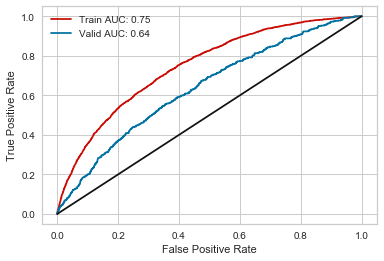

In [19]:
# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

clf = BernoulliNB()
#clf = MultinomialNB()
#clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Multinomial

         Score  Train Validation
0          AUC  0.663      0.674
1     Accuracy  0.626      0.560
2    Precision  0.611      0.087
3       Recall  0.695      0.695
4           F1  0.325      0.078
5  Specificity  0.557      0.552
6   Prevalence  0.501      0.058


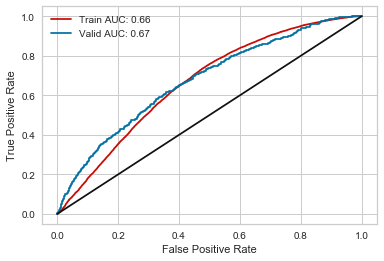

In [20]:
# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

#clf = BernoulliNB()
clf = MultinomialNB()
#clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Complement

         Score  Train Validation
0          AUC  0.663      0.674
1     Accuracy  0.626      0.561
2    Precision  0.611      0.087
3       Recall  0.693      0.690
4           F1  0.325      0.077
5  Specificity  0.558      0.554
6   Prevalence  0.501      0.058


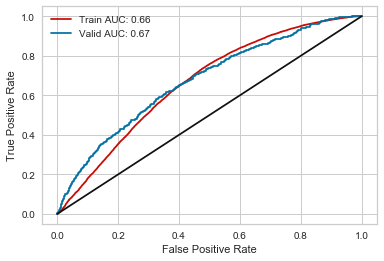

In [21]:
# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

#clf = BernoulliNB()
#clf = MultinomialNB()
clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Gaussian

         Score  Train Validation
0          AUC  0.678      0.644
1     Accuracy  0.599      0.345
2    Precision  0.564      0.070
3       Recall  0.884      0.839
4           F1  0.344      0.065
5  Specificity  0.313      0.314
6   Prevalence  0.501      0.058


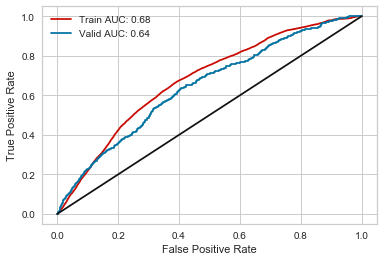

In [22]:
# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

#clf = MultinomialNB()
#clf = ComplementNB()
clf = GaussianNB()
train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Logistic Regression

         Score  Train Validation
0          AUC  0.678      0.664
1     Accuracy  0.634      0.583
2    Precision  0.622      0.088
3       Recall  0.685      0.662
4           F1  0.326      0.078
5  Specificity  0.582      0.578
6   Prevalence  0.501      0.058


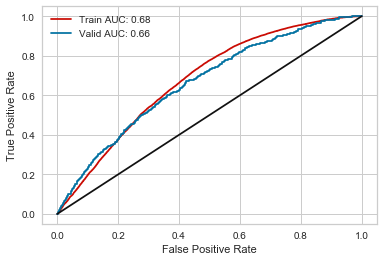

In [23]:
# Define Classifier - Default Settings
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

###  Random Forest

         Score  Train Validation
0          AUC  1.000      0.608
1     Accuracy  1.000      0.940
2    Precision  1.000      0.286
3       Recall  1.000      0.024
4           F1  0.500      0.022
5  Specificity  1.000      0.996
6   Prevalence  0.501      0.058


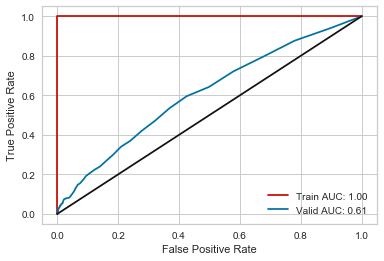

In [24]:
# Define Classifier - Default Settings
clf = RandomForestClassifier(random_state = random_state, n_estimators = 100)

# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Gradient Boost Classifier

Generally runs too slow. Stick with XGBoost.

C:\Users\canfi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


         Score  Train Validation
0          AUC  0.978      0.646
1     Accuracy  0.956      0.942
2    Precision  1.000      0.000
3       Recall  0.913      0.000
4           F1  0.477        nan
5  Specificity  1.000      1.000
6   Prevalence  0.501      0.058


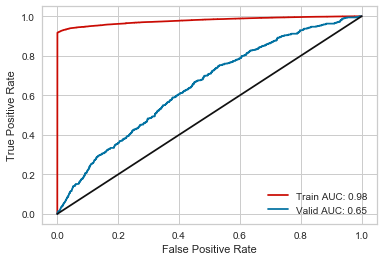

In [25]:
# Define Classifier - Default Settings
clf = GradientBoostingClassifier(random_state = random_state)

# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Ada Boost Classifier

         Score  Train Validation
0          AUC  0.964      0.618
1     Accuracy  0.922      0.911
2    Precision  0.960      0.111
3       Recall  0.881      0.077
4           F1  0.459      0.045
5  Specificity  0.963      0.962
6   Prevalence  0.501      0.058


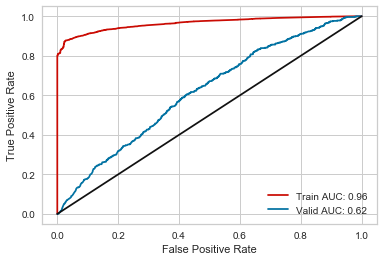

In [26]:
# Define Classifier - Default Settings
clf = AdaBoostClassifier(random_state = random_state)

# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### XGBoost

In [47]:
# # Define Classifier - Default Settings
# clf = XGBClassifier(random_state = random_state)

# # Define X/Y Values
# x_tr = x_tr_adasyn
# x_v = x_v
# y_tr = y_tr_adasyn
# y_v = y_v

# train_model_default(clf, x_tr, x_v, y_tr, y_v)

In [30]:
x_v.shape

(8775, 42)

In [31]:
x_tr.shape

(49818, 42)

In [32]:
y_tr.shape

(49818,)

In [33]:
y_v.shape

(8775,)

## Parameter Optimization

After analyzing a suite of classifiers using default setting, the following four classifiers returned quality results, so we will move forward with these models.

* Naive Bayes
* KNNeighbors
* XGBoost Classifier

#### Define X Y 

In [84]:
# Define X/Y Values
x_tr = x_tr_adasyn
x_v = x_v
y_tr = y_tr_adasyn
y_v = y_v

### Naive Bayes

Naive Bayes cannot use the dimensionally reduced matrices due to negative values.

#### Bernoulli

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  55 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.1s finished


Best parameters set found on training set:

{'alpha': 1e-05}

0.673 (+/-0.038) for {'alpha': 1e-05}
0.673 (+/-0.038) for {'alpha': 0.0001}
0.673 (+/-0.038) for {'alpha': 0.001}
0.673 (+/-0.038) for {'alpha': 0.01}
0.673 (+/-0.038) for {'alpha': 0.1}
0.673 (+/-0.038) for {'alpha': 1.0}
0.673 (+/-0.039) for {'alpha': 10.0}
0.672 (+/-0.039) for {'alpha': 100.0}
0.667 (+/-0.038) for {'alpha': 1000.0}
0.656 (+/-0.032) for {'alpha': 10000.0}
0.649 (+/-0.030) for {'alpha': 100000.0}

         Score  Train Validation
0          AUC  0.746      0.637
1     Accuracy  0.675      0.606
2    Precision  0.656      0.084
3       Recall  0.738      0.585
4           F1  0.347      0.074
5  Specificity  0.613      0.607
6   Prevalence  0.501      0.058


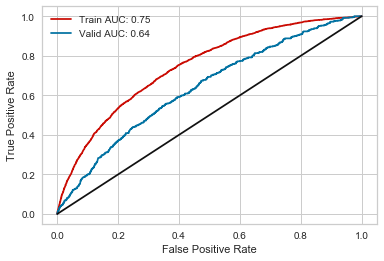

In [81]:
#Define Parameters
alpha = np.logspace(-5, 5, 11)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

# Establish Classifier
clf = BernoulliNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_ber_opt = clf

#### Gaussian

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished


Best parameters set found on training set:

{'var_smoothing': 1e-05}

0.560 (+/-0.012) for {'var_smoothing': 1e-09}
0.563 (+/-0.011) for {'var_smoothing': 1e-08}
0.567 (+/-0.013) for {'var_smoothing': 1e-07}
0.580 (+/-0.015) for {'var_smoothing': 1e-06}
0.601 (+/-0.014) for {'var_smoothing': 1e-05}
0.483 (+/-0.010) for {'var_smoothing': 0.0001}
0.439 (+/-0.036) for {'var_smoothing': 0.001}

         Score  Train Validation
0          AUC  0.705      0.662
1     Accuracy  0.629      0.391
2    Precision  0.585      0.074
3       Recall  0.892      0.829
4           F1  0.353      0.068
5  Specificity  0.365      0.364
6   Prevalence  0.501      0.058


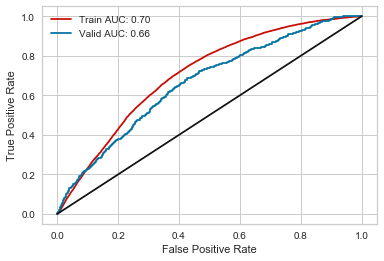

In [75]:
#Define Parameters
var_smoothing = np.logspace(-9, -3, 7)

#priors = np.linspace(.01, .99, 10).astype('float')

# Create hyperparameter options
hyperparameters = dict(var_smoothing = var_smoothing)

# Establish Classifier
clf = GaussianNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_gaus_opt = clf

#### Complement

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished


Best parameters set found on training set:

{'alpha': 2335.7214690901214, 'norm': 'True'}

0.342 (+/-0.003) for {'alpha': 1.0, 'norm': 'True'}
0.342 (+/-0.003) for {'alpha': 1.0, 'norm': 'False'}
0.344 (+/-0.004) for {'alpha': 1.6237767391887217, 'norm': 'True'}
0.344 (+/-0.004) for {'alpha': 1.6237767391887217, 'norm': 'False'}
0.346 (+/-0.005) for {'alpha': 2.636650898730358, 'norm': 'True'}
0.346 (+/-0.005) for {'alpha': 2.636650898730358, 'norm': 'False'}
0.349 (+/-0.005) for {'alpha': 4.281332398719393, 'norm': 'True'}
0.349 (+/-0.005) for {'alpha': 4.281332398719393, 'norm': 'False'}
0.351 (+/-0.007) for {'alpha': 6.951927961775605, 'norm': 'True'}
0.351 (+/-0.007) for {'alpha': 6.951927961775605, 'norm': 'False'}
0.353 (+/-0.007) for {'alpha': 11.28837891684689, 'norm': 'True'}
0.353 (+/-0.007) for {'alpha': 11.28837891684689, 'norm': 'False'}
0.355 (+/-0.008) for {'alpha': 18.329807108324356, 'norm': 'True'}
0.355 (+/-0.008) for {'alpha': 18.329807108324356, 'norm': 'False'}
0.

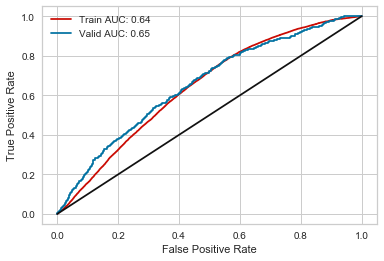

In [76]:
#Define Parameters
alpha = np.logspace(0, 4, 20)

norm = ['True', 'False']

# Create hyperparameter options
hyperparameters = dict(alpha = alpha, norm = norm)

# Establish Classifier
clf = ComplementNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_comp_opt = clf

#### MultiNomial

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished


Best parameters set found on training set:

{'alpha': 10.0}

0.619 (+/-0.018) for {'alpha': 0.0001}
0.619 (+/-0.018) for {'alpha': 0.001}
0.619 (+/-0.018) for {'alpha': 0.01}
0.619 (+/-0.018) for {'alpha': 0.1}
0.619 (+/-0.018) for {'alpha': 1.0}
0.619 (+/-0.018) for {'alpha': 10.0}
0.619 (+/-0.018) for {'alpha': 100.0}
0.610 (+/-0.022) for {'alpha': 1000.0}
0.457 (+/-0.119) for {'alpha': 10000.0}

         Score  Train Validation
0          AUC  0.663      0.674
1     Accuracy  0.626      0.561
2    Precision  0.611      0.087
3       Recall  0.695      0.694
4           F1  0.325      0.077
5  Specificity  0.557      0.553
6   Prevalence  0.501      0.058


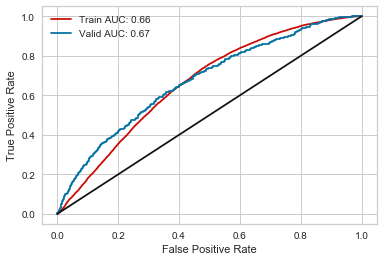

In [83]:
#Define Parameters
alpha = np.logspace(-4, 4, 9)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

# Establish Classifier
clf = ComplementNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_mn_opt = clf

### KNNeighbors

#### Define Function Inputs

In [85]:
# Establish Classifier
clf = KNeighborsClassifier()

#Define Parameters
n_neighbors  = np.linspace(2,12,6).astype('int') 
weights = ('uniform', 'distance')
metric = ('euclidean', 'manhattan')

# Create hyperparameter options
hyperparameters = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:  3.4min finished


Best parameters set found on training set:

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

0.856 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.868 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.831 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
0.842 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
0.770 (+/-0.006) for {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.787 (+/-0.006) for {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.760 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
0.776 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
0.720 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
0.741 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
0.716 (+/-0.014) for {'metric':

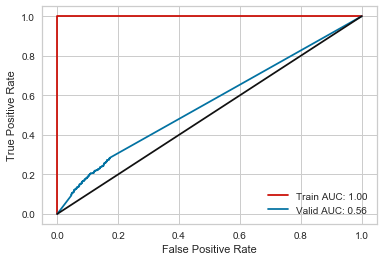

In [86]:
clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_knn_opt = clf

### Logistic Regression

#### Define Function Inputs

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 29.3min finished


Best parameters set found on training set:

{'C': 0.1, 'penalty': 'l1'}

0.548 (+/-0.017) for {'C': 0.001, 'penalty': 'l1'}
0.620 (+/-0.020) for {'C': 0.001, 'penalty': 'l2'}
0.621 (+/-0.015) for {'C': 0.01, 'penalty': 'l1'}
0.626 (+/-0.019) for {'C': 0.01, 'penalty': 'l2'}
0.627 (+/-0.018) for {'C': 0.1, 'penalty': 'l1'}
0.626 (+/-0.019) for {'C': 0.1, 'penalty': 'l2'}
0.626 (+/-0.019) for {'C': 1.0, 'penalty': 'l1'}
0.625 (+/-0.018) for {'C': 1.0, 'penalty': 'l2'}
0.625 (+/-0.018) for {'C': 10.0, 'penalty': 'l1'}
0.625 (+/-0.018) for {'C': 10.0, 'penalty': 'l2'}
0.625 (+/-0.018) for {'C': 100.0, 'penalty': 'l1'}
0.625 (+/-0.018) for {'C': 100.0, 'penalty': 'l2'}
0.625 (+/-0.018) for {'C': 1000.0, 'penalty': 'l1'}
0.625 (+/-0.018) for {'C': 1000.0, 'penalty': 'l2'}

         Score  Train Validation
0          AUC  0.678      0.665
1     Accuracy  0.634      0.583
2    Precision  0.622      0.088
3       Recall  0.686      0.662
4           F1  0.326      0.078
5  Specificity  0.582   

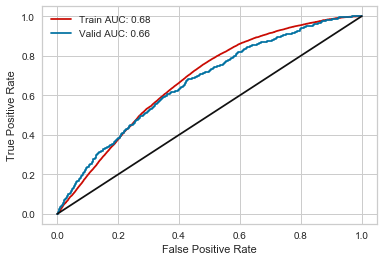

In [92]:
# Establish Classifier
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

#Define Parameters
penalty = ['l1','l2']       
C = np.logspace(-3, 3, 7)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty = penalty)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_log_opt = clf

### Random Forest

Random Forest models have so far performed so-so, and have taken a very long time to run. For the training data it often overfits to match 100%. I recommend commenting out these models until final analysis

#### Define Function Inputs

In [ ]:
# # Establish Classifier
# clf = RandomForestClassifier(random_state = random_state)

# #Define Parameters
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 


# # Create hyperparameter options
# hyperparameters = dict(n_estimators=n_estimators, 
#                        max_depth=max_depth,
#                        min_samples_split = min_samples_split,
#                        min_samples_leaf = min_samples_leaf)

In [ ]:
# clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

# opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# # Define for Test Analysis
# clf_rf_opt_pre = clf

### Ada Boost

#### Define Function Inputs

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.7min finished


Best parameters set found on training set:

{'learning_rate': 1.0, 'n_estimators': 600}

0.877 (+/-0.080) for {'learning_rate': 0.1, 'n_estimators': 300}
0.899 (+/-0.086) for {'learning_rate': 0.1, 'n_estimators': 400}
0.914 (+/-0.094) for {'learning_rate': 0.1, 'n_estimators': 500}
0.925 (+/-0.100) for {'learning_rate': 0.1, 'n_estimators': 600}
0.960 (+/-0.116) for {'learning_rate': 1.0, 'n_estimators': 300}
0.961 (+/-0.115) for {'learning_rate': 1.0, 'n_estimators': 400}
0.962 (+/-0.116) for {'learning_rate': 1.0, 'n_estimators': 500}
0.962 (+/-0.116) for {'learning_rate': 1.0, 'n_estimators': 600}
0.449 (+/-0.022) for {'learning_rate': 10.0, 'n_estimators': 300}
0.449 (+/-0.022) for {'learning_rate': 10.0, 'n_estimators': 400}
0.449 (+/-0.022) for {'learning_rate': 10.0, 'n_estimators': 500}
0.449 (+/-0.022) for {'learning_rate': 10.0, 'n_estimators': 600}



C:\Users\canfi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


         Score  Train Validation
0          AUC  0.979      0.657
1     Accuracy  0.964      0.942
2    Precision  1.000      0.000
3       Recall  0.928      0.000
4           F1  0.481        nan
5  Specificity  1.000      1.000
6   Prevalence  0.501      0.058


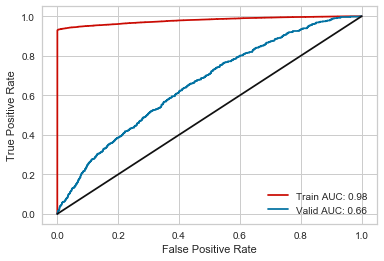

In [91]:
# Establish Classifier
clf = AdaBoostClassifier(random_state = random_state)

#Define Parameters
n_estimators = [300, 400, 500, 600]
learning_rate = np.logspace(-1, 1, 3)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       learning_rate=learning_rate)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_ada_opt = clf

### XGBoost

#### Define Function Inputs

In [ ]:
# #Define X/Y Values
# x_tr = x_tr_adasyn_svd
# x_v = x_v_svd
# y_tr = y_tr_adasyn
# y_v = y_v

# # Establish Classifier
# clf = XGBClassifier(random_state = random_state)

# #Define Parameters
# n_estimators = [25, 50, 100, 150, 200]
# learning_rate = np.logspace(-4, 1, 6)

# # Create hyperparameter options
# hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

# clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

# opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# # Define for Test Analysis
# clf_xbg_opt_pre = clf

# Test Set Scoring

## General Function

In [97]:
def test_score (clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    print(classification_report(y_true, y_pred, digits = 3))
    print()
    
    prevalence_te = '%.3f' %calc_prevalence(y_true)
    auc_score_te = '%.3f' %roc_auc_score(y_true, y_pred)
    print('AUC Score: ', auc_score_te)
    print('Positive Target Prevalence: ', prevalence_te)
    

In [101]:
def test_score_cv(clf, x):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y_te)
    print('positive target prevalence: ', prevalence_te)

## Naive Bayes

### Overall Metrics

In [99]:
test_score(clf_nb_ber_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.954     0.614     0.747      8241
           1      0.084     0.545     0.145       534

    accuracy                          0.609      8775
   macro avg      0.519     0.579     0.446      8775
weighted avg      0.901     0.609     0.710      8775


AUC Score:  0.579
Positive Target Prevalence:  0.061


### Cross Validation

In [102]:
test_score_cv(clf_nb_ber_opt, x_te)

fit_time : 0.012
score_time : 0.023
test_roc_auc : 0.633
test_accuracy : 0.938
test_balanced_accuracy : 0.502
test_precision : 0.130
test_recall : 0.006
test_f1 : 0.011
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## KNNeighbors

### Overall Metrics

In [103]:
test_score(clf_knn_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.944     0.895     0.919      8241
           1      0.097     0.174     0.125       534

    accuracy                          0.851      8775
   macro avg      0.520     0.535     0.522      8775
weighted avg      0.892     0.851     0.870      8775


AUC Score:  0.535
Positive Target Prevalence:  0.061


### Cross Validation

In [104]:
test_score_cv(clf_knn_opt, x_te)

fit_time : 0.017
score_time : 0.653
test_roc_auc : 0.524
test_accuracy : 0.925
test_balanced_accuracy : 0.510
test_precision : 0.129
test_recall : 0.037
test_f1 : 0.058
positive target prevalence:  0.061


## Logistic Regression

### Overall Metrics

In [105]:
test_score(clf_log_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.960     0.575     0.719      8241
           1      0.087     0.629     0.154       534

    accuracy                          0.578      8775
   macro avg      0.524     0.602     0.436      8775
weighted avg      0.907     0.578     0.685      8775


AUC Score:  0.602
Positive Target Prevalence:  0.061


### Cross Validation

In [106]:
test_score_cv(clf_log_opt, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undef

fit_time : 14.709
score_time : 0.014
test_roc_auc : 0.625
test_accuracy : 0.939
test_balanced_accuracy : 0.500
test_precision : 0.000
test_recall : 0.000
test_f1 : 0.000
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Ada Boost

### Overall Metrics

In [ ]:
#test_score(clf_ada_opt_pre, x_te_pre)

### Cross Validation

In [ ]:
#test_score_cv(clf_ada_opt_pre, x_te_pre)

## XGBoost

### Overall Metrics

In [ ]:
#test_score(clf_xbg_opt_pre, x_te_pre)

### Cross Validation

In [ ]:
#test_score_cv(clf_xbg_opt_pre, x_te_pre)